In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/it-service-ticket-classification-dataset/all_tickets_processed_improved_v3.csv


# Libraries

In [60]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import torch
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
import ipywidgets as widgets
from IPython.display import display

In [35]:
import transformers
print(transformers.__version__)

4.52.4


# Train / Val / Test

In [36]:
df = pd.read_csv('/kaggle/input/it-service-ticket-classification-dataset/all_tickets_processed_improved_v3.csv')

In [37]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Document'], df['Topic_group'], test_size=0.2, stratify=df['Topic_group'], random_state=42
)

In [38]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.1, stratify=train_labels, random_state=42
)

In [39]:
test_df = pd.DataFrame({"Document": test_texts, "Topic_group": test_labels})
test_df.to_csv("test_data.csv", index=False)
print("Test df is saved:", test_df.shape)

Test df is saved: (9568, 2)


In [40]:
print("Train size:", len(train_texts))
print("Validation size:", len(val_texts))
print("Test size:", len(test_df))

Train size: 34442
Validation size: 3827
Test size: 9568


# Encoding

In [41]:
label2id = {
    "Hardware": 0,
    "HR Support": 1,
    "Access": 2,
    "Miscellaneous": 3,
    "Storage": 4,
    "Purchase": 5,
    "Internal Project": 6,
    "Administrative rights": 7
}

In [42]:
id2label = {v: k for k, v in label2id.items()}

In [43]:
train_labels = train_labels.map(label2id)
val_labels = val_labels.map(label2id)

In [44]:
test_labels = [label2id[label] for label in test_labels]

# Tokinization

In [45]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [46]:
def tokenize(batch):
    return tokenizer(batch, padding=True, truncation=True, max_length=256)

In [47]:
train_encodings = tokenize(list(train_texts))
val_encodings = tokenize(list(val_texts))
test_encodings = tokenize(list(test_texts))

# Dataset

In [48]:
class TicketDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = list(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = TicketDataset(train_encodings, train_labels)
val_dataset = TicketDataset(val_encodings, val_labels)
test_dataset = TicketDataset(test_encodings, test_labels)

In [49]:
test_dataset = TicketDataset(test_encodings, test_labels)

# Model

In [50]:
print(torch.cuda.is_available())      
print(torch.cuda.device_count())      
print(torch.cuda.get_device_name(0))

True
1
Tesla P100-PCIE-16GB


In [51]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=8)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

In [53]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="epoch",
    logging_steps=50,
    load_best_model_at_end=True,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [54]:
trainer.train()

trainer.save_model("./ticket_classifier")
tokenizer.save_pretrained("./ticket_classifier")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.702400,0.425665,0.856023,0.856701,0.856023,0.855743
2,0.357800,0.374266,0.871178,0.871823,0.871178,0.870886
3,0.260000,0.374046,0.872485,0.872227,0.872485,0.872080


('./ticket_classifier/tokenizer_config.json',
 './ticket_classifier/special_tokens_map.json',
 './ticket_classifier/vocab.txt',
 './ticket_classifier/added_tokens.json',
 './ticket_classifier/tokenizer.json')

In [55]:
!zip -r ticket_classifier.zip ./ticket_classifier

  adding: ticket_classifier/ (stored 0%)
  adding: ticket_classifier/config.json (deflated 54%)
  adding: ticket_classifier/model.safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 8%)
  adding: ticket_classifier/special_tokens_map.json (deflated 42%)
  adding: ticket_classifier/tokenizer_config.json (deflated 75%)
  adding: ticket_classifier/vocab.txt (deflated 53%)
  adding: ticket_classifier/tokenizer.json (deflated 71%)
  adding: ticket_classifier/training_args.bin (deflated 51%)


In [56]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.3670171797275543,
 'eval_accuracy': 0.8776128762541806,
 'eval_precision': 0.8773117580415096,
 'eval_recall': 0.8776128762541806,
 'eval_f1': 0.8773030608962351,
 'eval_runtime': 35.8626,
 'eval_samples_per_second': 266.796,
 'eval_steps_per_second': 8.337,
 'epoch': 3.0}

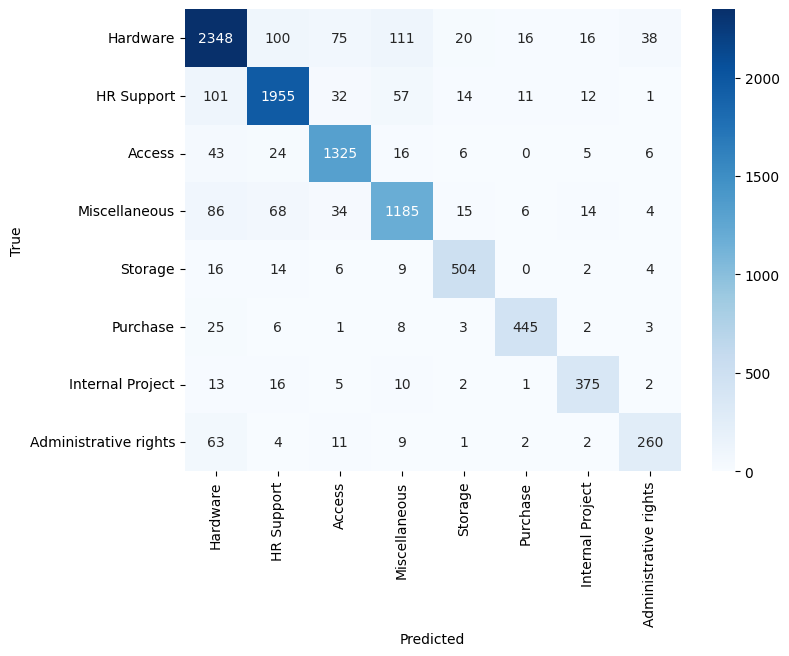

In [61]:
preds = trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred, labels=list(label2id.values()))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label2id.keys(), yticklabels=label2id.keys(), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [62]:
classification_report(y_true, y_pred, target_names=label2id.keys())

'                       precision    recall  f1-score   support\n\n             Hardware       0.87      0.86      0.87      2724\n           HR Support       0.89      0.90      0.89      2183\n               Access       0.89      0.93      0.91      1425\n        Miscellaneous       0.84      0.84      0.84      1412\n              Storage       0.89      0.91      0.90       555\n             Purchase       0.93      0.90      0.91       493\n     Internal Project       0.88      0.88      0.88       424\nAdministrative rights       0.82      0.74      0.78       352\n\n             accuracy                           0.88      9568\n            macro avg       0.88      0.87      0.87      9568\n         weighted avg       0.88      0.88      0.88      9568\n'

# Sample Prediction

In [63]:
def predict_ticket(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    pred_id = torch.argmax(logits, dim=1).item()  
    pred_label = id2label[pred_id]
    return pred_label

In [64]:
ticket = 'create record net which points to thursday pm dear please create record which points thanks regards engineer' #Access, 2

In [65]:
predicted_class = predict_ticket(ticket)
print(f"Model classified the ticket as: {predicted_class}")

Model classified the ticket as: Access


# Widget

In [66]:
text_input = widgets.Textarea(
    value='',
    placeholder='Enter the text here...',
    description='Ticket:',
    layout=widgets.Layout(width='80%', height='100px')
)

output_label = widgets.Label(value="Result: ")

button = widgets.Button(description="Predict the category")

def on_button_clicked(b):
    text = text_input.value
    if text.strip() == "":
        output_label.value = "Result: please enter the text"
    else:
        prediction = predict_ticket(text)
        output_label.value = f"Result: {prediction}"

button.on_click(on_button_clicked)


display(text_input, button, output_label)

Textarea(value='', description='Ticket:', layout=Layout(height='100px', width='80%'), placeholder='Enter the t…

Button(description='Predict the category', style=ButtonStyle())

Label(value='Result: ')